# Variational Autoencoders
Here, by using variational autoencoders, we are going to create new faces. along with that, we are going to experiment with 
the help of trained encoder and decoder like morphing faces, adding accessories, changing face expression.  
Orginal paper link : https://arxiv.org/abs/1312.6114  
<!-- ![image.png](attachment:image.png) -->

<img src="https://learnopencv.com/wp-content/uploads/2020/11/vae-diagram-1-1024x563.jpg" width="600" height="400">

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras import (layers,models,callbacks,utils,metrics,losses,optimizers)

from scipy.stats import norm
import pandas as pd
import cv2
import os

In [3]:
# setting parameters
IMAGE_SIZE = 64    # n=64 for nxn image
CHANNELS = 3       # for rgb layers
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200       #latent space dimension
LEARNING_RATE = 0.0005
EPOCHS = 20
BETA = 2000
LOAD_MODEL = True

In [4]:
## showing images from dataset
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
#     if images.max() > 1.0:
#         images = images / 255.0
#     elif images.min() < 0.0:
#         images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

# preparing the data

In [5]:
# for seeing the specific img
im = "archive/img_align_celeba/img_align_celeba/100001.jpg"
img = cv2.imread(im)
# img = img/255.0
# img = tf.cast(img, dtype=tf.float32)
# with open('X_train.npy', 'wb') as f:
#     np.save(f, img)
print(img.dtype)
cv2.imshow("img",img)
cv2.waitKey(0) ##//(n)--->>n millisecs 0---->>>for infinite time till crossed
cv2.destroyAllWindows()

uint8


In [38]:
from IPython.display import clear_output

train_dataset = []
dataset_path = os.path.join(os.getcwd(),"archive/img_align_celeba/img_align_celeba")

i = 0

for file_name in os.listdir(dataset_path):
    if(i >= 51200): #'''162816'''
        break
    if(i%100 == 0):
        clear_output(wait=True)
        print(i)
    img = cv2.imread(os.path.join(dataset_path,file_name))
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
    img = img/255.0
    img = tf.cast(img, dtype=tf.float32)
    train_dataset.append(img)
    i = i+1
#X_train = np.array(train_dataset)

51100


In [6]:
#saved npy file for future use of numpy
# with open('X_train.npy', 'wb') as f:
#     np.save(f, train_dataset)
# import pickle
# with open("test", "wb") as fp:   #Pickling
#     pickle.dump(train_dataset, fp)
# with open("test", "rb") as fp:   # Unpickling
#     b = pickle.load(fp)

In [7]:
# # convert the 0-255 levels in images to 0-1 for better model training
# X_train = np.array(train_dataset)/255.0
# X_train = tf.cast(X_train, dtype=tf.float32)
# print(X_train.dtype)

In [5]:
# X_train = np.array(train_dataset)
# print(X_train.shape)
# display(X_train,size=(20,3))

# Variational Autoencoder model

Here, in the Sampling class, by subclassing it from Layer class of keras, so that we can create a new type of layer, to output one of obvservation of normal distribution with z_mean and z_log_var as mean,log value of its variance respectively.  
The log of varince is taken because, variance usually lie in positive region,but output of distributon comes from (-inf,+inf), so to accomodate that, we taking its log value.

In [6]:
class Sampling(layers.Layer):
    def call(self,inputs):
        z_mean,z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim   = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape = (batch,dim))
        return z_mean + tf.exp(0.5*z_log_var)*epsilon

In [7]:
#encoder design in Vae
encoder_input = layers.Input(shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS), name = "encoder_input")

x = layers.Conv2D(NUM_FEATURES,kernel_size=3,strides=2,padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
for i in range(4):
    x = layers.Conv2D(NUM_FEATURES,kernel_size=3,strides=2,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

z_mean = layers.Dense(Z_DIM,name = "z_mean")(x)
z_log_var = layers.Dense(Z_DIM,name = "z_log_var")(x)

z = Sampling()([z_mean,z_log_var])

encoder = models.Model(encoder_input,[z_mean,z_log_var,z],name = "encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]

In [8]:
#decoder design
decoder_input = layers.Input((Z_DIM,),name = "decoder_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)

for i in range(5):
    x = layers.Conv2DTranspose(NUM_FEATURES,(3,3),strides=2,padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

decoder_output = layers.Conv2DTranspose(CHANNELS,kernel_size=3,strides=1,activation="sigmoid",padding = "same")(x)

decoder = models.Model(decoder_input,decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 64)         36928     
 nspose)                                                     

### VAE custom class model
here, we break down the custom model of VAE which is a subclass of keras Model.  
**call method:** The call method is overridden in the custom model class. Inside the call method, you define the forward pass of the model by specifying how the input data flows through the layers.  
**train step method:** the model (self) is called with the input data (data) and the training=True argument. This call invokes the model's __call__ method, which typically defines the forward pass of the model.The tape automatically watches all the operations that occur within its context, including the operations performed by the model during the forward pass. after that, it calculates gradients and updates all the losses. after that it returns a dictionary with name as key and metric as value.  
**test step method:** except, the gradient and optimization part, it does exactly what happended in train step method.

In [9]:
class VAE(models.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean("total_loss")
        self.reconstruction_loss_tracker = metrics.Mean("reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean("kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self,inputs):
        """Call the model in the particular input"""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean,z_log_var,reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean,z_log_var,reconstruction = self(data,training = True)
            reconstruction_loss = tf.reduce_mean(BETA*losses.mean_squared_error(data,reconstruction))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5*(1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var)),axis = 1))
            
            total_loss = reconstruction_loss + kl_loss
        
        #calculating gradients using Gradienttape backwards and using optimizers to speed the update process
        grads = tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self,data):
        """Step run during validation."""
        if isinstance(data,tuple):
            data = data[0]
        z_mean,z_log_var,reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA*losses.mean_squared_error(data,reconstruction))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5*(1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var)),axis = 1))

        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [10]:
# Instantiate vae using custom class VAE
vae = VAE(encoder,decoder)

# Training

In [11]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [12]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="logs")
# class ImageGenerator(callbacks.Callback):
#     def __init__(self, num_img, latent_dim):
#         self.num_img = num_img
#         self.latent_dim = latent_dim

#     def on_epoch_end(self, epoch, logs=None):
#         random_latent_vectors = tf.random.normal(
#             shape=(self.num_img, self.latent_dim)
#         )
#         generated_images = self.model.decoder(random_latent_vectors)
#         generated_images *= 255
#         generated_images.numpy()
#         for i in range(self.num_img):
#             img = generated_images[i]
#             loca = "output\\%03d\\generated_img_%d.png" % (epoch, i)
#             cv2.imwrite(loca, img)

In [13]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("models_trained\\vae")
    #tmp = vae.predict(X_train.take(1))

In [41]:
vae.fit(
    X_train,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks=[
        model_checkpoint_callback,
        #tensorboard_callback,
        #ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 75.6636 - reconstruction_loss: 60.3484 - kl_loss: 14.6580

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


400/400 [==============================] - 511s 1s/step - loss: 75.6619 - reconstruction_loss: 60.3484 - kl_loss: 14.6580
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 73.4142 - reconstruction_loss: 57.9941 - kl_loss: 14.7722

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


400/400 [==============================] - 628s 2s/step - loss: 73.4126 - reconstruction_loss: 57.9941 - kl_loss: 14.7722
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 71.0907 - reconstruction_loss: 55.5062 - kl_loss: 15.2548

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


400/400 [==============================] - 585s 1s/step - loss: 71.0898 - reconstruction_loss: 55.5062 - kl_loss: 15.2548
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 69.8354 - reconstruction_loss: 54.1126 - kl_loss: 15.6099

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


400/400 [==============================] - 519s 1s/step - loss: 69.8351 - reconstruction_loss: 54.1126 - kl_loss: 15.6099
Epoch 5/10
400/400 [==============================] - ETA: 0s - loss: 68.8753 - reconstruction_loss: 53.0929 - kl_loss: 15.7111

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


400/400 [==============================] - 561s 1s/step - loss: 68.8752 - reconstruction_loss: 53.0929 - kl_loss: 15.7111
Epoch 6/10
400/400 [==============================] - ETA: 0s - loss: 68.2496 - reconstruction_loss: 52.5291 - kl_loss: 15.7650

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


400/400 [==============================] - 498s 1s/step - loss: 68.2498 - reconstruction_loss: 52.5291 - kl_loss: 15.7650
Epoch 7/10
400/400 [==============================] - ETA: 0s - loss: 68.1242 - reconstruction_loss: 52.2197 - kl_loss: 15.8379

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


400/400 [==============================] - 489s 1s/step - loss: 68.1241 - reconstruction_loss: 52.2197 - kl_loss: 15.8379
Epoch 8/10
400/400 [==============================] - ETA: 0s - loss: 67.7875 - reconstruction_loss: 51.8126 - kl_loss: 15.8750

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


400/400 [==============================] - 510s 1s/step - loss: 67.7872 - reconstruction_loss: 51.8126 - kl_loss: 15.8750
Epoch 9/10
400/400 [==============================] - ETA: 0s - loss: 67.5121 - reconstruction_loss: 51.4577 - kl_loss: 15.9964

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


400/400 [==============================] - 500s 1s/step - loss: 67.5120 - reconstruction_loss: 51.4577 - kl_loss: 15.9964
Epoch 10/10
400/400 [==============================] - ETA: 0s - loss: 67.0112 - reconstruction_loss: 50.9886 - kl_loss: 16.0708

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


400/400 [==============================] - 508s 1s/step - loss: 67.0113 - reconstruction_loss: 50.9886 - kl_loss: 16.0708


In [42]:
# Save the final models
vae.save("models\\vae")
encoder.save("models\\encoder")
decoder.save("models\\decoder")

INFO:tensorflow:Assets written to: models\vae\assets


INFO:tensorflow:Assets written to: models\vae\assets


INFO:tensorflow:Assets written to: models\encoder\assets


INFO:tensorflow:Assets written to: models\encoder\assets


INFO:tensorflow:Assets written to: models\decoder\assets


INFO:tensorflow:Assets written to: models\decoder\assets


In [17]:
# check the performance of VAE
# X_test = X_train[40030:40050,:,:,:]
# X_test.shape

In [15]:
# z_mean, z_log_var, reconstructions = vae.predict(X_test)
# print("Example real faces")
# display(X_test)
# print("Reconstructions")
# display(reconstructions)

# testing with test data

In [16]:
test_dataset = []
dataset_path = os.path.join(os.getcwd(),"archive/img_align_celeba/img_align_celeba")
files = os.listdir(dataset_path)[76048:76068]
for file_name in files:
    img = cv2.imread(os.path.join(dataset_path,file_name))
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
    img = img/255.0
    img = tf.cast(img, dtype=tf.float32)
    test_dataset.append(img)
X_test = np.array(test_dataset)

In [17]:
print(X_test.shape)

(20, 64, 64, 3)


1/1 [==============================] - 2s 2s/step
Example real faces


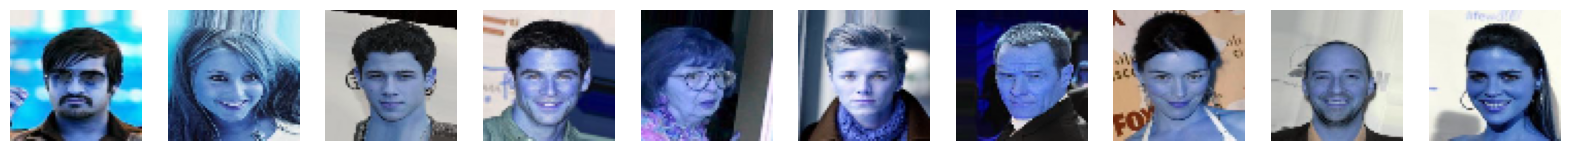

Reconstructions


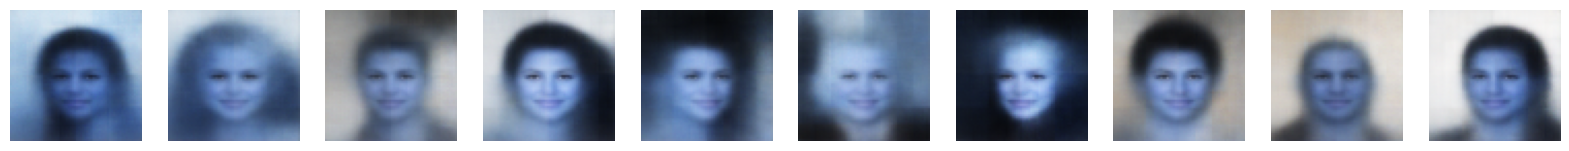

In [18]:
z_mean, z_log_var, reconstructions = vae.predict(X_test)
print("Example real faces")
display(X_test)
print("Reconstructions")
display(reconstructions)

In [19]:
img = reconstructions[0]
img = cv2.resize(img, (178,218),interpolation = cv2.INTER_LINEAR)
cv2.imshow("img",img)
cv2.waitKey(0) ##//(n)--->>n millisecs 0---->>>for infinite time till crossed
cv2.destroyAllWindows()

# Custom images reconstruction

In [31]:
imgs= []
dataset_path = os.path.join(os.getcwd(),"imgs")

for file_name in os.listdir(dataset_path):
    img = cv2.imread(os.path.join(dataset_path,file_name))
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
    img = img/255.0
    img = tf.cast(img, dtype=tf.float32)
    imgs.append(img)
imgs = np.array(imgs)

In [33]:
z_mean, z_log_var, reconstructions = vae.predict(imgs)
print(reconstructions.shape)
rf = []
ref = []
for i in range(4):
    tmp = cv2.resize(imgs[i], (178,218),interpolation = cv2.INTER_LINEAR)
    tmp1 = cv2.resize(reconstructions[i], (178,218),interpolation = cv2.INTER_LINEAR)
    rf.append(tmp)
    ref.append(tmp1)

rf = cv2.hconcat([rf[0],rf[1],rf[2],rf[3]])
ref = cv2.hconcat([ref[0],ref[1],ref[2],ref[3]])
im = cv2.vconcat([rf,ref])
cv2.imshow("img",im)
cv2.waitKey(0) ##//(n)--->>n millisecs 0---->>>for infinite time till crossed
cv2.destroyAllWindows()

1/1 [==============================] - 0s 72ms/step
(5, 64, 64, 3)
